In [9]:
%%javascript
$.getScript('http://asimjalis.github.io/ipyn-ext/js/ipyn-present.js')

<IPython.core.display.Javascript object>

<h1 class="tocheading">Batch Layer</h1>
<div id="toc"></div>

Objectives
---------------------------------------------------------------------
By the end of today's lesson, you will be able to:  
* Describe and employ the four communication patterns of distributed processing
* Develop and implement a DAG for batch processing

Computing on the batch layer
---------------------------------------------------------------------
**The roles of the Lambda Architecture layers in servicing queries on the dataset**
![Figure 6.1](06fig01_alt.jpg)

## Precomputing a query by running a function on the master dataset directly

---------------------------------------------------------------------

$$\text{query} = function(􏰁\text{all data}􏰂)$$

---------------------------------------------------------------------

![Figure 6.2](06fig02.jpg)

## Splitting a query into pre-computation and on-the-fly components

---------------------------------------------------------------------

$$
\begin{align*}
􏰁\text{batch view} &= function(􏰁\text{all data}􏰂)\\
\text{query} &= function(􏰁\text{batch view}􏰂)
\end{align*}
$$

---------------------------------------------------------------------

![Figure 6.3](06fig03_alt.jpg)

### Computing the number of pageviews by querying an indexed batch view
![Figure 6.4](06fig04_alt.jpg)

Recomputation algorithms vs. incremental algorithms
---------------------------------------------------------------------
**A recomputing algorithm to update the number of records in the master dataset. New data is appended to the master dataset, and then all records are counted.**
![Figure 6.5](06fig05_alt.jpg)

---------------------------------------------------------------------

**An incremental algorithm to update the number of records in the master dataset. Only the new dataset is counted, with the total used to update the batch view directly.**
![Figure 6.6](06fig06_alt.jpg)

### Performance
**A comparison between a recomputation view and an incremental view for determining the number of unique visitors per URL**
![Figure 6.7](06fig07_alt.jpg)

### Human-fault tolerance

* Recomputation alogrithms tolerate human fault well (just recompute after the bug is fixed)
* Data from incremental algorithms are difficult to impossible to repair after human error

### Generality of the algorithms

* Recomputation algorithms are generally more extensible.
* Incremental algorithms do *violence to the data* and are irreversable

### Choosing a style of algorithm
**Comparing recomputation and incremental algorithms**

|                       | Recomputation algorithms | Incremental algorithms |
|:--------------------- |:------------------------ |:---------------------- |
| Performance           | Requires computational effort to process the entire master dataset | Requires less computational resources but may generate much larger batch views |
| Human-fault tolerance | Extremely tolerant of human errors because the batch views are continually rebuilt | Doesn’t facilitate repairing errors in the batch views; repairs are ad hoc and may require estimates |
| Generality            | Complexity of the algorithm is addressed during precomputation, resulting in simple batch views and low-latency, on-the-fly processing | Requires special tailoring; may shift complexity to on-the-fly query processing |
| Conclusion            | Essential to supporting a robust data-processing system | Can increase the efficiency of your system, but only as a supplement to recomputation algorithms |

Directed Acyclic Graphs (a.k.a. Pipe Diagrams)
---------------------------------------------------------------------
**a higher-level way of thinking about batch computation**

In [2]:
%load_ext gvmagic

### Modified word-count pipe diagram

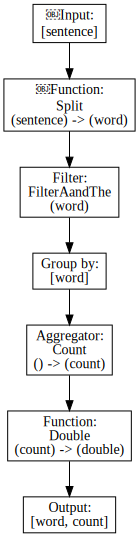

In [3]:
%%dot digraph {  
    # rankdir=LR;
    node [shape=box]
    
    Input      [label = "￼Input:\n[sentence]"]
    function1  [label = "￼Function:\nSplit\n(sentence) -> (word)"]
    Filter     [label = "Filter:\nFilterAandThe\n(word)"]
    groupby    [label = "Group by:\n[word]"]
    aggregator [label = "Aggregator:\nCount\n() -> (count)"]
    function2  [label = "Function:\nDouble\n(count) -> (double)"]
    Output     [label = "Output:\n[word, count]"]
    
    Input -> function1;
    function1 -> Filter;
    Filter -> groupby;
    groupby -> aggregator;
    aggregator -> function2;
    function2 -> Output;
}

<!--
| Illustration of a DAG function | Illustration of a DAG filter |
|:------------------------------:|:----------------------------:|
| ![Figure 6.16](06fig16.jpg)    | ![Figure 6.17](06fig17.jpg)  |
-->
## Fields are automatically discarded when no longer needed.
![Figure 6.20](06fig20_alt.jpg)

## Compute the number of males each person follows
![Figure 6.23](06fig23.jpg)

## Communication Patterns
### None
* Map  
* Filter  
(embarassingly parallel)  

### All-to-one
* Reduce

### One-to-all
* Broadcast

### All-to-all
* reduceByKey
* groupyByKey
* Join

![Narrow vs Wide Dependenceis](dependencies.png)

---------------------------------------------------------------------

## Execution of sum aggregator and sum buffer at the MapReduce level
![Figure 7.15](07fig15_alt.jpg)

---------------------------------------------------------------------

## Execution of a sum parallel aggregator at the MapReduce level
![Figure 7.16](07fig16_alt.jpg)

---------------------------------------------------------------------

Example Batch Layer: SuperWebAnalytics.com
==========================================
Design of the SuperWebAnalytics.com batch layer
---------------------------------------------------------------------
### Supported queries
* Pageview counts by URL sliced by time
* Unique visitors by URL sliced by time
* Bounce-rate analysis  

**Examples of different pageviews for the same person being captured using different identifiers**
![Figure 8.1](08fig01_alt.jpg)

## Batch views
<!--#### PAGEVIEWS OVER TIME-->
**Precomputing pageviews with an hourly granularity**
![Figure 8.2](08fig02_alt.jpg)  

**Optimizing pageviews over large query ranges using coarser granularities**
![Figure 8.3](08fig03_alt.jpg)

**Number of buckets in a one-year period for each granularity**

| Granularity | # buckets in 1 yr. |
|:-----------:| ---------------------------:|
| hourly      |  8760 |
| daily       | ~ 365 |
| weekly      |  ~ 52 |
| monthly     |  ~ 13 |

Workflow overview
---------------------------------------------------------------------
**Batch workflow for SuperWebAnalytics.com**
![Figure 8.5](08fig05_alt.jpg)

Ingesting new data
---------------------------------------------------------------------
![Figure 4.8](04fig08_alt.jpg)
![Figure 5.1](05fig01_alt.jpg)

URL normalization
---------------------------------------------------------------------
**URL-normalization DAG**

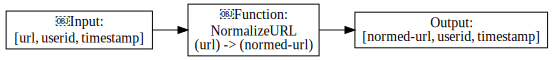

In [4]:
%%dot digraph {  
    rankdir=LR;
    
    Input    [label = "￼Input:\n[url, userid, timestamp]", shape = box]
    Function [label = "￼Function:\nNormalizeURL\n(url) -> (normed-url)", shape = box]
    Output   [label = "Output:\n[normed-url, userid, timestamp]", shape = box]
    
    Input -> Function;
    Function -> Output;
}

User-identifier normalization
---------------------------------------------------------------------
**Example equiv graph**
![Figure 8.7](08fig07.jpg)
**Mapping from user IDs to a single identifier for each set**
![Figure 8.8](08fig08.jpg)

*GraphX has a [ConnectedComponents](https://spark.apache.org/docs/latest/graphx-programming-guide.html#connected-components) algorithm that can be used for this purpose*

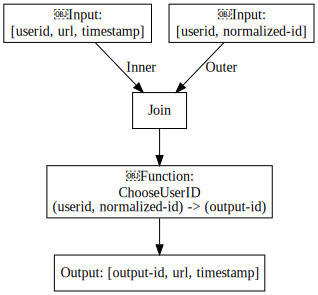

In [5]:
%%dot digraph {
    node [shape=box]
    
    Input1   [label = "￼Input:\n[userid, url, timestamp]"]
    Input2   [label = "￼Input:\n[userid, normalized-id]"]
    Function [label = "￼Function:\nChooseUserID\n(userid, normalized-id) -> (output-id)"]
    Output   [label = "Output: [output-id, url, timestamp]"]

    Input1 -> Join [label=Inner];
    Input2 -> Join [label=Outer];
    Join -> Function;
    Function -> Output;
}

Deduplicate pageviews
---------------------------------------------------------------------
**Deduplication DAG**
<!--![Figure 8.15](08fig15.jpg)-->

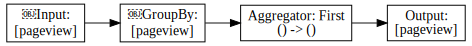

In [6]:
%%dot digraph {  
    rankdir=LR;
    
    Input      [label = "￼Input:\n[pageview]", shape = box]
    GroupBy    [label = "￼GroupBy:\n[pageview]", shape = box]
    Aggregator [label = "Aggregator: First\n() -> ()", shape = box]
    Output     [label = "Output:\n[pageview]", shape = box]
    
    Input -> GroupBy;
    GroupBy -> Aggregator;
    Aggregator -> Output;
}

Computing batch views
---------------------------------------------------------------------
### Pageviews over time
**Computing hourly granularities for pageviews over time**

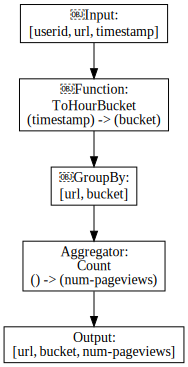

In [7]:
%%dot digraph {
    node [shape=box]
    
    Input      [label = "￼Input:\n[userid, url, timestamp]"]
    Function   [label = "￼Function:\nToHourBucket\n(timestamp) -> (bucket)"]
    GroupBy    [label = "￼GroupBy:\n[url, bucket]"]
    Aggregator [label = "Aggregator:\nCount\n() -> (num-pageviews)"]
    Output     [label = "Output:\n[url, bucket, num-pageviews]"]
    
    Input -> Function;
    Function -> GroupBy;
    GroupBy -> Aggregator;
    Aggregator -> Output;
}

Lab
===============================================================
Leveraging the work you did in `hdfs2`, load the page view data from `SuperWebAnalytics/master/page_view` and write batch jobs (in Spark) to do the following:
1. URL normalization (strip '`http://`', '`#`'s, '`?`'s, etc.)
2. Deduplicate page views
3. Roll up page-views over time (by hour, day, week, and month)